In [4]:
import sys

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets
from dal_toolbox.models.utils.mcdropout import MCDropoutModule, ConsistentMCDropout
from dal_toolbox.models.mc_dropout.train import train_one_epoch

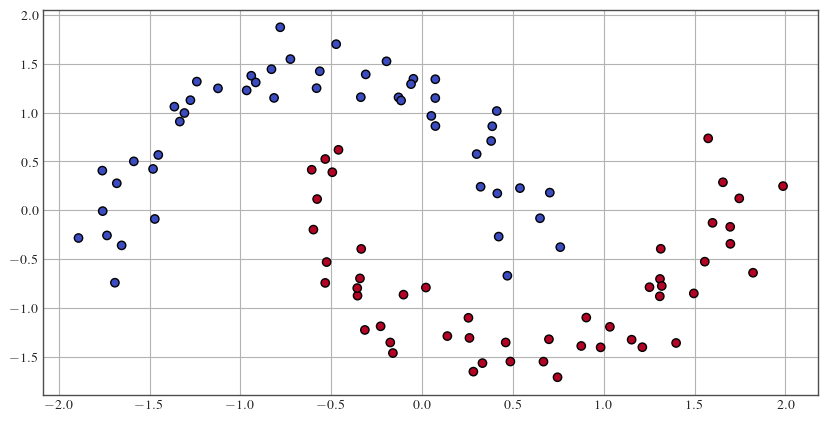

In [5]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [24]:
import abc
from typing import Any
import lightning as L

class MCDropout(L.LightningModule, MCDropoutModule, abc.ABC):

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        loss = F.cross_entropy(logits, targets)
        self.log('loss', loss, prog_bar=True)
        return loss

    def mc_forward_impl(self, x):
        return self.forward(x)

class Net(MCDropout):
    def __init__(self,
                 num_classes: int,
                 dropout_rate: int = .2,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = ConsistentMCDropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = ConsistentMCDropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        return out

    def configure_optimizers(self):
        optimizer_params = dict(
            lr=1e-2,
            weight_decay=0,
            momentum=.9,
        )
        optimizer = torch.optim.SGD(self.parameters(), **optimizer_params)
        return optimizer


In [22]:
class MetricsCallback(L.Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_train_epoch_end(self, trainer, module):
        metrics = {k: v.item() for k, v in trainer.logged_metrics.items()}
        self.metrics.append(metrics)

    def __iter__(self):
        return iter(self.metrics)

In [28]:
@torch.no_grad()
def plot_contour(model, X, y, ax=None):
    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model.mc_forward(zz)
    probas = logits.softmax(-1)
    probas = probas.mean(1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params
-------------------------------------------------------
0 | first          | Linear              | 384   
1 | first_dropout  | ConsistentMCDropout | 0     
2 | hidden         | Linear              | 16.5 K
3 | hidden_dropout | ConsistentMCDropout | 0     
4 | last           | Linear              | 258   
5 | act            | ReLU                | 0     
-------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers whi

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 204.13it/s, v_num=32, loss=0.059] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 136.41it/s, v_num=32, loss=0.059]


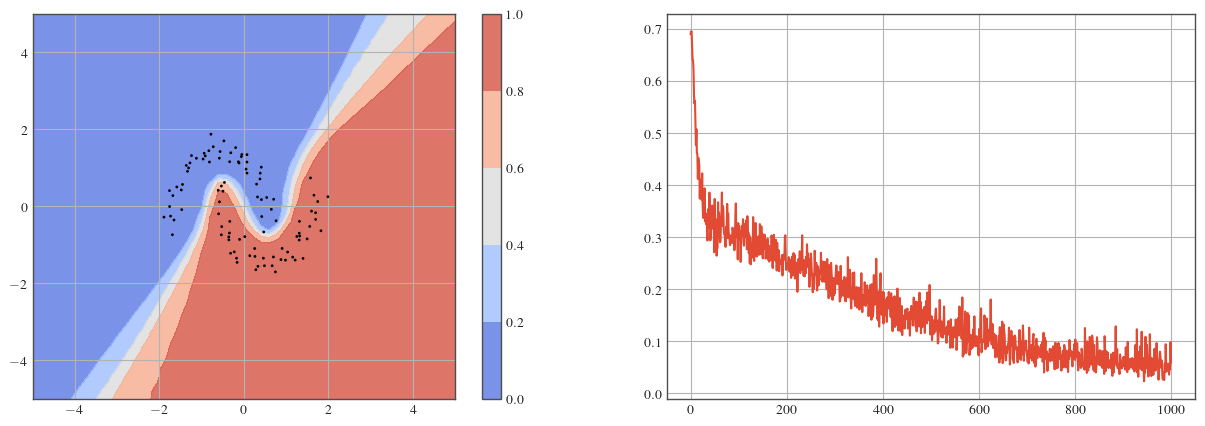

In [31]:
dropout_rate = 0.6
num_epochs = 1000
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = Net(dropout_rate=dropout_rate, num_classes=2)
history = MetricsCallback()
trainer = L.Trainer(max_epochs=num_epochs, callbacks=[history])
trainer.fit(model, train_loader)

model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot([d['loss'] for d in history])
plot_contour(model, X, y, ax=plt.subplot(121))
plt.show()